## Step 1: Camera Calibration

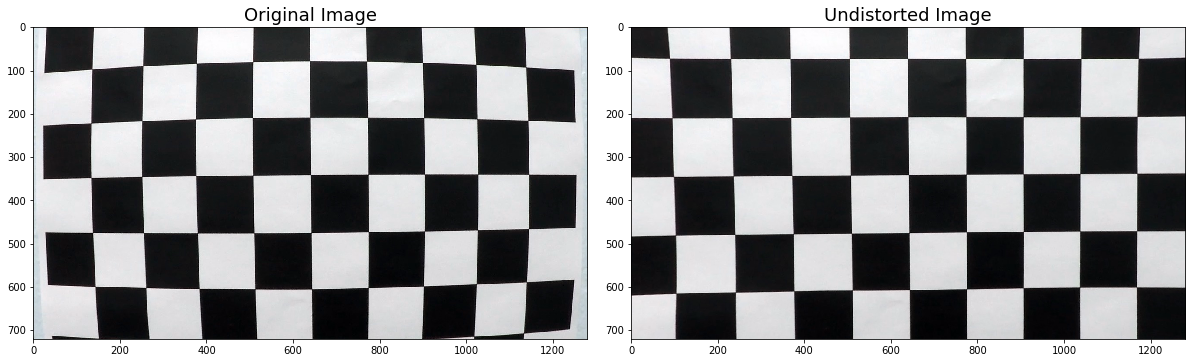

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline

def camera_calibration(images_path, image_size):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)   
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(images_path+'/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
         
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)

    cv2.destroyAllWindows()        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size,None,None)
    
    #save the mtx and dist as calib_dist_pickle.p
    out_path =  images_path+"/calib_dist_pickle.p"   
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( out_path, "wb" ) )
     
    return out_path

import_image = 'camera_cal/calibration1.jpg'
image = cv2.imread(import_image)

file_patch = 'camera_cal'
image_size = (image.shape[1], image.shape[0])
out_path = camera_calibration(file_patch, image_size)

dist_pickle = pickle.load( open(out_path, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

undist = cv2.undistort(image, mtx, dist, None, mtx)

cv2.imwrite('output_images/undistort_output.jpg',undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=18)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Step 2: Distortion-corrected image

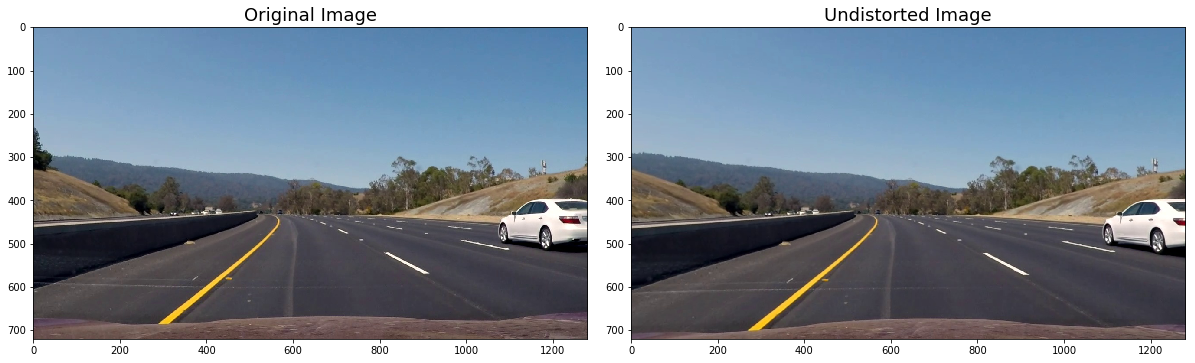

In [29]:
origin_img = cv2.imread('test_images/image_out1.jpg')
origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)

undist_pipline = cv2.undistort(origin_img, mtx, dist, None, mtx)

cv2.imwrite('output_images/undistort_pipline.jpg',cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(origin_img)
ax1.set_title('Original Image', fontsize=18)
ax2.imshow(undist_pipline)
ax2.set_title('Undistorted Image', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Step 3: Color transforms, gradients

###  Looking for suitable gradients

In [30]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

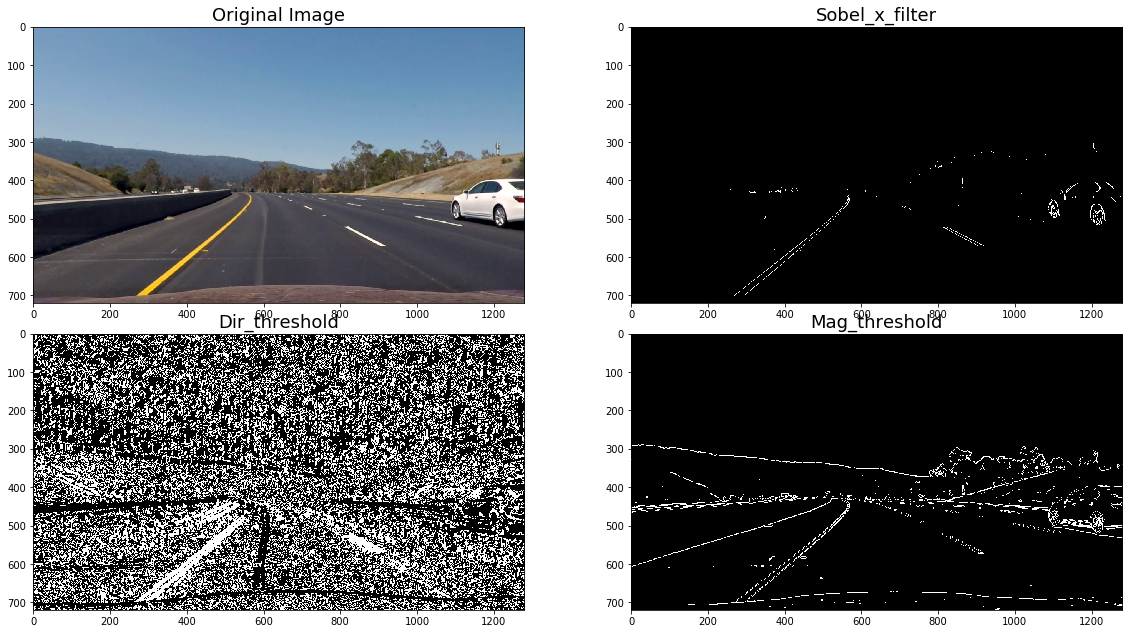

In [31]:
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undist_pipline, orient='x', sobel_kernel=3, thresh=(75, 255))

mag_binary = mag_thresh(undist_pipline, sobel_kernel=3, mag_thresh=(40, 100))
dir_binary = dir_threshold(undist_pipline, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
f, axs = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
axs[0, 0].imshow(undist_pipline)
axs[0, 0].set_title('Original Image', fontsize=18)
axs[0, 1].imshow(gradx, cmap='gray')
axs[0, 1].set_title('Sobel_x_filter', fontsize=18)
axs[1, 0].imshow(dir_binary, cmap='gray')
axs[1, 0].set_title('Dir_threshold', fontsize=18)
axs[1, 1].imshow(mag_binary, cmap='gray')
axs[1, 1].set_title('Mag_threshold', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

###  Looking for suitable color thresholded binary image

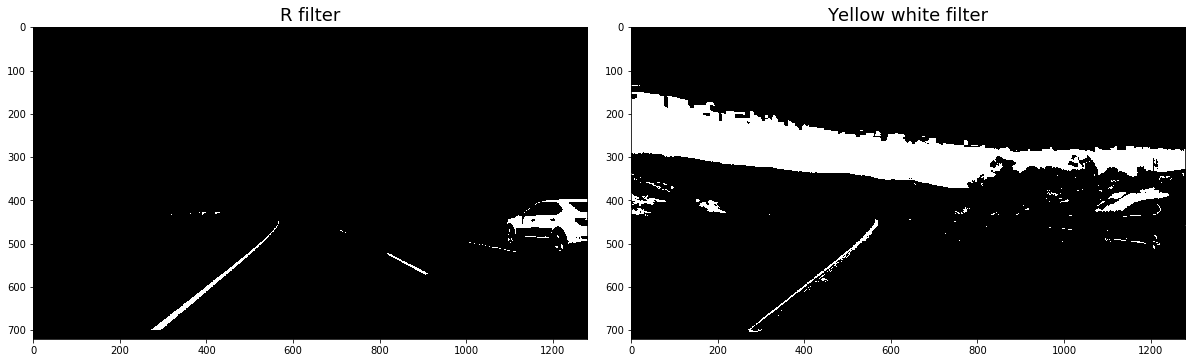

In [32]:
def r_select(img, thresh=(200, 255)):
    R = img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def apply_yellow_white_mask(img):
    image_HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    yellow_hsv_low  = np.array([ 0,  100,  100])
    yellow_hsv_high = np.array([ 80, 180, 255])
    white_hsv_low  = np.array([ 90,   0,   170])
    white_hsv_high = np.array([ 160,  80, 255])   
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_YW_image = cv2.bitwise_or(mask_yellow,mask_white)
    return mask_YW_image

r_binary = r_select(undist_pipline, thresh=(220, 255))
yw_binary = apply_yellow_white_mask(undist_pipline)
# Plot the result
f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(r_binary, cmap='gray')
axs[0].set_title('R filter', fontsize=18)
axs[1].imshow(yw_binary, cmap='gray')
axs[1].set_title('Yellow white filter', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

###  Looking for suitable HLS color channel

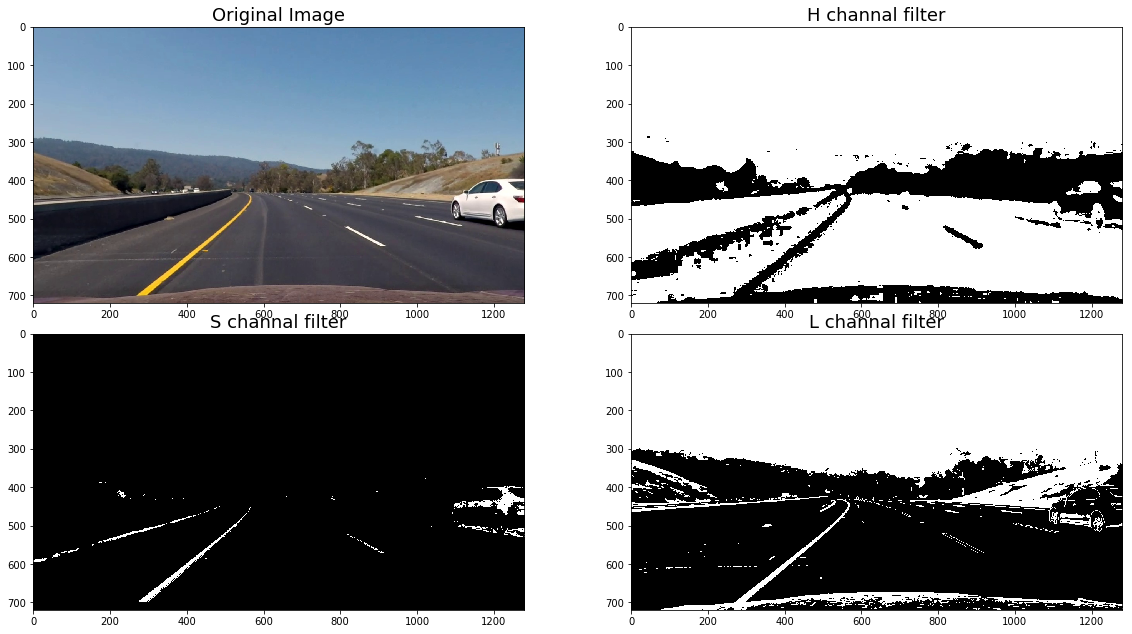

In [33]:
def hls_select(img, channel='S', thresh=(90, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'S':
        X = hls[:, :, 2]
    elif channel == 'H':
        X = hls[:, :, 0]
    elif channel == 'L':
        X = hls[:, :, 1]
    else:
        #print('illegal channel !!!')
        return
    binary_output = np.zeros_like(X)
    binary_output[(X > thresh[0]) & (X <= thresh[1])] = 1
    return binary_output

l_binary = hls_select(undist_pipline, channel='L', thresh=(100, 200))
s_binary = hls_select(undist_pipline, channel='S', thresh=(180, 255))
h_binary = hls_select(undist_pipline, channel='H', thresh=(100, 255))
f, axs = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
axs[0, 0].imshow(undist_pipline)
axs[0, 0].set_title('Original Image', fontsize=18)
axs[0, 1].imshow(h_binary, cmap='gray')
axs[0, 1].set_title('H channal filter', fontsize=18)
axs[1, 0].imshow(s_binary, cmap='gray')
axs[1, 0].set_title('S channal filter', fontsize=18)
axs[1, 1].imshow(l_binary, cmap='gray')
axs[1, 1].set_title('L channal filter', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

###  Looking for suitable combine_filters

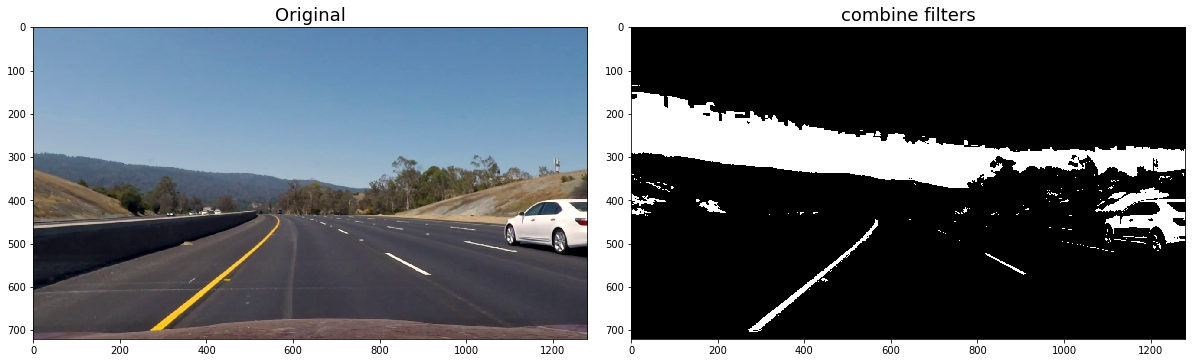

In [34]:
def combine_filters(img):
    r_binary = r_select(undist_pipline, thresh=(220, 255))
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 255))
    l_binary = hls_select(img, channel='L', thresh=(100, 200))
    s_binary = hls_select(img, channel='S', thresh=(180, 255))
    h_binary = hls_select(img, channel='H', thresh=(100, 255))
    yw_binary = apply_yellow_white_mask(undist_pipline)
    yw_binary[(yw_binary !=0)] = 1
    combined_lsx = np.zeros_like(gradx)
    
    combined_lsx[((s_binary==1)&(l_binary ==1)|(yw_binary ==1)|(r_binary == 1))] = 1
    #combined_lsx[((yw_binary ==1)|(r_binary == 1))] = 1
    return combined_lsx

binary = combine_filters(undist_pipline)

combined_binary_image = np.dstack(( binary, binary, binary))*255
cv2.imwrite('output_images/binary_combine_image.jpg',combined_binary_image)

f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(undist_pipline)
axs[0].set_title('Original', fontsize=18)
axs[1].imshow(binary, cmap='gray')
axs[1].set_title('combine filters', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Step 4: Perspective Transform

###  Looking for 4 warped points(a,b,c,d) 

a [562, 470]
b [713, 470]
c [1204, 720]
d [253, 720]


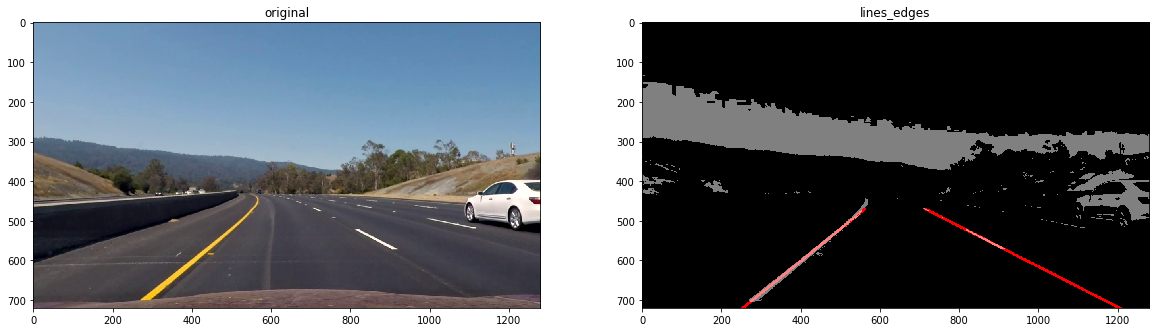

In [35]:
class Point(object):
    x =0
    y= 0
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

class Line(object):
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2


def GetLinePara(line):
    line.a =line.p1.y - line.p2.y;
    line.b = line.p2.x - line.p1.x;
    line.c = line.p1.x *line.p2.y - line.p2.x * line.p1.y;


def GetCrossPoint(l1,l2):

    GetLinePara(l1);
    GetLinePara(l2);
    d = l1.a * l2.b - l2.a * l1.b
    p=Point()
    p.x = (int)(l1.b * l2.c - l2.b * l1.c)*1.0 / d
    p.y = (int)(l1.c * l2.a - l2.c * l1.a)*1.0 / d
    return p;

def slop_line(point1, point2):
    a = (point1.y - point2.y)/(point1.x - point2.x)
    b = point1.y - point1.x*a
    return a, b
    

def region_thresholds(x,y):
    left_bottom = [200,680]
    right_bottom = [1130,680]
    apex_right = [740,460]
    apex_left = [580,460]

    
    fit_left = np.polyfit((left_bottom[0], apex_left[0]), (left_bottom[1], apex_left[1]), 1)
    fit_top = np.polyfit((apex_left[0], apex_right[0]), (apex_left[1], apex_right[1]), 1)
    #fit_right = np.polyfit((apex_right[0], right_bottom[0]), (apex_right[1], right_bottom[1]), 1)
    fit_right = np.polyfit(( right_bottom[0], apex_right[0]), (right_bottom[1],apex_right[1]), 1)
    fit_bottom = np.polyfit((right_bottom[0], left_bottom[0]), (right_bottom[1], left_bottom[1]), 1)

    if((y > (x*fit_left[0] + fit_left[1])) & (y > (x*fit_top[0] + fit_top[1])) & (y > (x*fit_right[0] + fit_right[1])) & (y < (x*fit_bottom[0] + fit_bottom[1]))):
        return 1
    else:
        return 0 
    

rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 3     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 6 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments

line_image = np.copy(combined_binary_image)*0 # creating a blank to draw lines on
region_binary = np.copy(binary) 
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
#lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
lines = cv2.HoughLinesP(region_binary, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)


# gather left_points right_point from the lines that have been classfied by hough
left_points = []
right_points =[]
center_col = 640 # in order to classfy left points and right points
# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        if (region_thresholds(x1,y1)):
            if x1 < center_col:
                left_points.append((x1,y1))
            if x1 > center_col:
                right_points.append((x1,y1))
            if(region_thresholds(x2,y2)):
                if x2 < center_col:
                    left_points.append((x2,y2))
                if x2 > center_col:
                    right_points.append((x2,y2))
                    
                                                                 
#left_line
rows,cols = line_image.shape[:2]
points = np.array(left_points)
[vx,vy,x,y] = cv2.fitLine(points, cv2.DIST_L2,1,0.01,0.01)
line_lefty = int((-x*vy/vx)+y)
line_righty = int(((cols-x)*vy/vx)+y)

#limit the lenth of left line
p1=Point(cols-1,line_righty)
p2=Point(0,line_lefty)

line1=Line(p1,p2)
p3=Point(0,470)
p4=Point(1210,470)
line2=Line(p3,p4)
Pc = GetCrossPoint(line1,line2);
ax = int(Pc.x)
ay = int(Pc.y)                  


#second line
p5=Point(0,720)
p6=Point(1210,720)
line3=Line(p5,p6)
Pc = GetCrossPoint(line1,line3);
dx = int(Pc.x)
dy = int(Pc.y)  

line_image = cv2.line(line_image,(0,line_lefty),(ax,ay),(255,0,0),5)

#right_line
points = np.array(right_points)
[vx,vy,x,y] = cv2.fitLine(points, cv2.DIST_L2,1,0.01,0.01)
line_lefty = int((-x*vy/vx) + y)
line_righty = int(((cols-x)*vy/vx)+y)
#lie_image = cv2.line(line_image,(cols-1,righty),(0,lefty),(0,0,255),3)

#limit the lenth of right line
p1=Point(cols-1,line_righty)
p2=Point(0,line_lefty)
line1=Line(p1,p2)

p3=Point(0,470)
p4=Point(1210,470)
line2=Line(p3,p4)
Pc = GetCrossPoint(line1,line2);
bx = int(Pc.x)
by = int(Pc.y)


Pc = GetCrossPoint(line1,line3);
cx = int(Pc.x)
cy = int(Pc.y)

line_image = cv2.line(line_image,(cols-1,line_righty),(bx,by),(255,0,0),5)
lines_edges = cv2.addWeighted(line_image, 1, combined_binary_image, 0.5, 0) 


print('a',[ax,ay])
print('b',[bx,by])
print('c',[cx,cy])
print('d',[dx,dy])

f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

ax1.set_title('original')
ax1.imshow(undist_pipline)

ax2.set_title('lines_edges')
ax2.imshow(lines_edges)

###  "birds-eye view"

a [562, 470]
b [713, 470]
c [1204, 720]
d [253, 720]
dist:a [125, 125]
dist:b [1155, 125]
dist:c [1155, 595]
dist:d [125, 595]


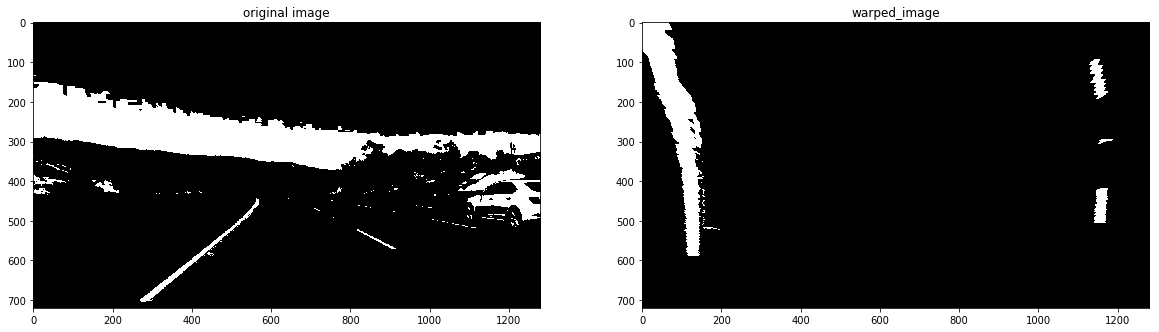

In [38]:
def perspective_transform(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def subplot(rows, cols, imgs):
    nums = rows * cols
    fig = plt.figure(1, figsize=(16, 9))
    for i in range(1, nums+1):
        plt.subplot(rows, cols, i)
        plt.imshow(imgs[i-1])

offset = 125
img_size = (cols,rows)

print('a',[ax,ay])
print('b',[bx,by])
print('c',[cx,cy])
print('d',[dx,dy])


# left_top to left_bottom(a, b, c, d),
src_corners = np.float32([(ax, ay), (bx, by), (cx, cy), (dx, dy)])
dst_corners = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                     [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])

print('dist:a', [offset, offset])
print('dist:b', [img_size[0]-offset, offset])
print('dist:c', [img_size[0]-offset, img_size[1]-offset])
print('dist:d', [offset, img_size[1]-offset])

M = cv2.getPerspectiveTransform(src_corners, dst_corners)
Minv = cv2.getPerspectiveTransform(dst_corners, src_corners)
warped_image = cv2.warpPerspective(binary, M, img_size)

#cv2.imwrite('output_images/warped_straight_lines.jpg',warped_image)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

ax1.set_title('original image')
ax1.imshow(binary, cmap = 'gray')

ax2.set_title('warped_image')
ax2.imshow(warped_image, cmap= 'gray')

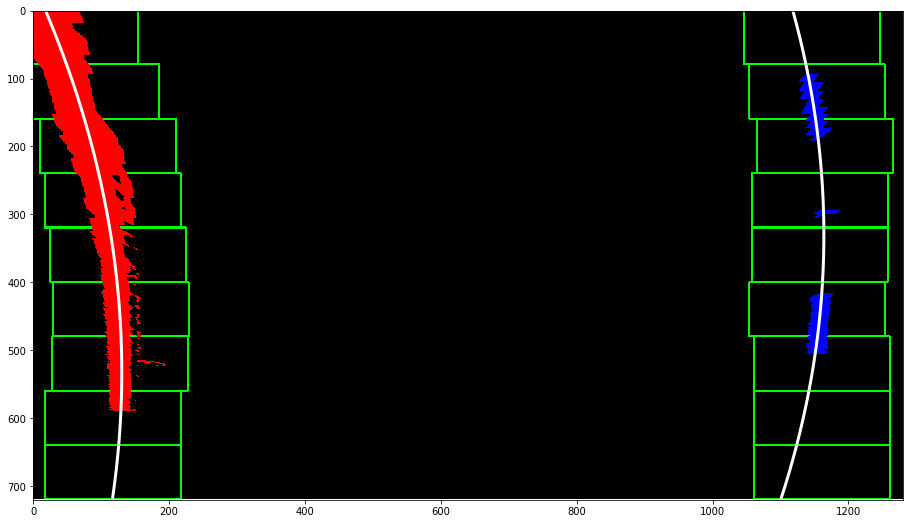

In [39]:
def find_line_fit(img, nwindows=9, margin=100, minpix=50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # to plot
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    return out_img, lefty, leftx, righty, rightx


# Generate x and y values for plotting
def get_fit_xy(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty


out_img, lefty, leftx, righty, rightx = find_line_fit(warped_image)

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

left_fitx, right_fitx, ploty = get_fit_xy(warped_image, left_fit, right_fit)

fig = plt.figure(figsize=(16, 9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='white', linewidth=3.0)
plt.plot(right_fitx, ploty, color='white',  linewidth=3.0)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Step 5:  warped image has been warped back the original image

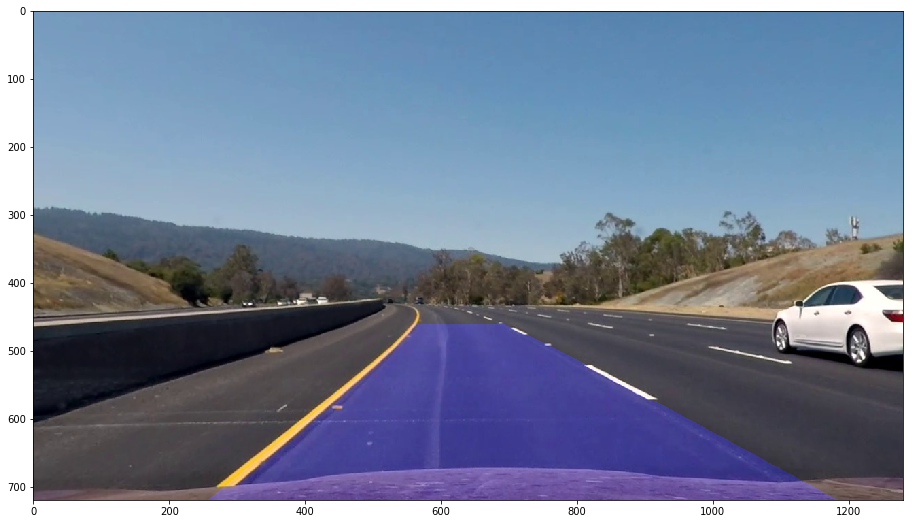

In [40]:
def project_back(wrap_img, origin_img, left_fitx, right_fitx, ploty, M):
    warp_zero = np.zeros_like(wrap_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 0, 255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform(color_warp, M)
    # Combine the result with the original image
    result = cv2.addWeighted(origin_img, 1, newwarp, 0.3, 0)
    return result

result = project_back(binary, undist_pipline, left_fitx, right_fitx, ploty, Minv)
fig = plt.figure(figsize=(16, 9))
plt.imshow(result)

### Step 6: Calculated the radius of curvature and the position of the vehicle with respect to center

###  Calculated the radius of curvature of the lane

In [15]:
def radius_curvature(ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    left_curverad = round(left_curverad, 2)
    right_curverad = round(right_curverad, 2)

    print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad

def diff_slops_traight_line(img, lefty, leftx, righty, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fit = np.polyfit(lefty, leftx, 1)
    right_fit = np.polyfit(righty, rightx, 1)
    line_left_fitx = left_fit[0]*ploty + left_fit[1]
    line_right_fitx = right_fit[0]*ploty + right_fit[1]
    
    #line_right_fitx2 = (left_fit[0]+0.1)*ploty + right_fit[1]
    
    print('left_fit:',left_fit)
    print('right_fit:',right_fit)
    diff_slop = np.absolute(left_fit[0] - right_fit[0])
    
    return diff_slop

    
left_curverad, right_curverad = radius_curvature(ploty, left_fit, right_fit)


1304.98486201 1388.80268639
415.2 m 393.25 m


### Calculate position of the vehicle with respect to center

In [16]:
def distance_center(image, leftx, rightx):
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    image_midpoint = np.int(image.shape[1]/2)
    center_pipline = (leftx + rightx)/2
    diff_center = np.absolute((center_pipline - image_midpoint)//2) * xm_per_pix
    diff_center = round(diff_center, 2)
    print('image_midpoint:', image_midpoint)
    print('center_pipline:', center_pipline)
    print('diff_center:', diff_center)

    if image_midpoint > center_pipline:
        vehicle_position = 'vehicle is '+str(diff_center)+'m right of center'
    if image_midpoint < center_pipline:
        vehicle_position = 'vehicle is '+str(diff_center)+' m left of center'
        
    return vehicle_position

vehicle_position_text = distance_center(undist_pipline, dx, cx)
print('vehicle_position_text', vehicle_position_text)

image_midpoint: 640
center_pipline: 728.5
diff_center: 0.23
vehicle_position_text vehicle is 0.23 m left of center
